# Concept Drift Detection Methods: Comparative Benchmark

## Abstract

This notebook presents a comprehensive benchmark of concept drift detection methods, comparing original research implementations from the backup folder (D3, DAWIDD, ShapeDD) with streaming methods from the River library. The evaluation follows the experimental design from `run__drift_detection.py`, using controlled synthetic data generation with known drift characteristics.

## Methods Evaluated

**Window-based Methods (Original Implementations):**
- D3: Discriminative drift detection using classifier performance
- DAWIDD: Drift detection with adapted windowing and independence distance
- ShapeDD: Shape-based drift detection using Maximum Mean Discrepancy

**Streaming Methods (River Library):**
- ADWIN: Adaptive sliding window with statistical bounds
- DDM/EDDM: Drift detection based on error rate monitoring
- HDDM variants: Histogram-based distribution monitoring

In [57]:
# Dependencies and Setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import psutil
import gc
from collections import deque
from tqdm import tqdm
import psutil
import gc
from collections import deque


# Scikit-learn imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score as roc
from sklearn.metrics.pairwise import pairwise_kernels as apply_kernel

# River drift detection methods
from river.drift import ADWIN
from river.drift.binary import DDM, EDDM, FHDDM, HDDM_A, HDDM_W

# Setup paths for local modules
import sys
import os
sys.path.insert(0, os.path.abspath('../backup'))

# Import original implementations
from gen_data import gen_random
from dawidd import dawidd
from shape_dd import shape
from d3 import d3

# Configuration
plt.style.use('seaborn-v0_8')
np.random.seed(42)
warnings.filterwarnings('ignore')


In [58]:
def calculate_prequential_accuracy(predictions, true_labels, window_size=100):
    """Calculate prequential (test-then-train) accuracy over time."""
    accuracies = []
    for i in range(len(predictions)):
        start_idx = max(0, i - window_size + 1)
        window_preds = predictions[start_idx:i+1]
        window_true = true_labels[start_idx:i+1]
        
        if len(window_preds) > 0:
            accuracy = np.mean(np.array(window_preds) == np.array(window_true))
            accuracies.append(accuracy)
        else:
            accuracies.append(0.0)
    
    return accuracies

def calculate_mttd_metrics(detections, true_drifts, acceptable_delta=100):
    """Calculate Mean Time To Detection and TP/FP/FN metrics."""
    tp = 0
    fp = 0
    fn = 0
    detection_delays = []
    
    # Create sets for faster lookup
    detection_set = set(detections)
    true_drift_set = set(true_drifts)
    
    # Calculate True Positives and detection delays
    for true_drift in true_drifts:
        detected = False
        min_delay = float('inf')
        
        for detection in detections:
            delay = detection - true_drift
            if 0 <= delay <= acceptable_delta:
                detected = True
                min_delay = min(min_delay, delay)
        
        if detected:
            tp += 1
            detection_delays.append(min_delay)
        else:
            fn += 1
    
    # Calculate False Positives
    for detection in detections:
        is_fp = True
        for true_drift in true_drifts:
            if 0 <= detection - true_drift <= acceptable_delta:
                is_fp = False
                break
        if is_fp:
            fp += 1
    
    mttd = np.mean(detection_delays) if detection_delays else float('inf')
    
    return {
        'mttd': mttd,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'detection_delays': detection_delays
    }

def monitor_resources():
    """Monitor memory usage."""
    process = psutil.Process()
    memory_mb = process.memory_info().rss / 1024 / 1024
    return memory_mb

def batch(X, chunk_size, overlap=100):
    """Original batch function from experiments."""
    shift = chunk_size - overlap
    res = []
    for i in range(int(X.shape[0]/(shift)) - int(chunk_size/shift) + 1):
        res.append(X[i*shift : min(chunk_size + i*shift, X.shape[0])])
    return res


In [59]:
def evaluate_window_based_method(
    X, y, true_drifts, method_name, chunk_size=150, overlap=0,
    cooldown=None, d3_threshold=0.5, dawidd_alpha=0.05, shape_alpha=0.05
):
    
    if cooldown is None:
        cooldown = chunk_size // 2

    start_mem = monitor_resources()
    t0_all = time.perf_counter()

    method_detections = []
    runtime_per_batch_ms = []
    drift_estimates = []
    true_drift_scores = []

    shift = chunk_size - overlap
    batches = []
    for i in range(int(X.shape[0]/(shift)) - int(chunk_size/shift) + 1):
        batch_indices = np.arange(i*shift, min(chunk_size + i*shift, X.shape[0]))
        batches.append(batch_indices)
    
    batch_count = len(batches)
    last_det = -10**9

    # CRITICAL FIX: Precompute ShapeDD with correct parameters
    shape_total_time_ms = 0.0
    if method_name == 'ShapeDD':
        t_shape0 = time.perf_counter()
        # Use chunk_size (not window_size) and extract column 2 (p-values) like original
        shp_full = shape(X, 50, chunk_size, 2500)
        shp_pvals = shp_full[:, 2]  # Extract p-values column
        t_shape1 = time.perf_counter()
        shape_total_time_ms = (t_shape1 - t_shape0) * 1000.0

    for b in batches:
        xb = X[b]
        yb = y[b]
        t1 = time.perf_counter()

        # Calculate true drift score (same as original)
        n = len(b)
        if n > 1:
            drift_score = (yb[None,:] != yb[:,None]).sum() / (len(yb) * (len(yb) - 1))
        else:
            drift_score = 0.0
        true_drift_scores.append(float(drift_score))

        try:
            if method_name == 'D3':
                # CRITICAL FIX: Test multiple classifiers like original
                d3_estimates = {
                    'linear': d3(xb),
                    'extra_trees': d3(xb, ExtraTreesClassifier(max_depth=5)),
                    'random_forest': d3(xb, RandomForestClassifier(max_depth=5)),
                    'knn': d3(xb, KNeighborsClassifier())
                }
                
                # Use linear as primary (like original "d3 (lin)")
                est = float(d3_estimates['linear'])
                
                # D3 returns (1 - AUC), so higher values = more drift
                trigger = (est > d3_threshold)
                det_pos = b[-1]

            elif method_name == 'DAWIDD':
                # CORRECT: This matches original implementation
                _, est = dawidd(xb, "rbf")  # Returns (statistic, p_value)
                est = float(est)  # p-value
                trigger = (est < dawidd_alpha)  # Low p-value = drift detected
                det_pos = b[-1]

            elif method_name == 'ShapeDD':
                # CRITICAL FIX: Use minimum p-value in batch (like original)
                batch_pvals = shp_pvals[b]
                est = float(batch_pvals.min())  # Direct minimum p-value (NO transformation)
                trigger = (est < shape_alpha)  # Low p-value = drift detected
                
                # Detection position at minimum p-value location
                min_idx = np.argmin(batch_pvals)
                det_pos = b[min_idx]

            else:
                raise ValueError(f"Unknown window method: {method_name}")

        except Exception as e:
            print(f"Error in {method_name}: {e}")
            est, trigger, det_pos = 0.0, False, b[-1]

        drift_estimates.append(est)

        # Apply cooldown to merge nearby detections
        if trigger and (det_pos - last_det >= cooldown):
            method_detections.append(int(det_pos))
            last_det = det_pos

        # Calculate batch runtime (following original timing methodology)
        batch_ms = (time.perf_counter() - t1) * 1000.0
        if method_name == 'ShapeDD':
            # Add precomputation time distributed across batches
            batch_ms += shape_total_time_ms / max(1, batch_count)
        runtime_per_batch_ms.append(batch_ms)

    total_time_s = time.perf_counter() - t0_all
    end_mem = monitor_resources()
    memory_mb = max(0.0, end_mem - start_mem)

    # Calculate correlation between estimates and true drift scores
    estimate_correlation = 0.0
    if len(drift_estimates) > 1 and len(true_drift_scores) > 1:
        try:
            # For D3: higher values = more drift (positive correlation expected)
            # For DAWIDD/ShapeDD: lower p-values = more drift (negative correlation expected)
            est_arr = np.asarray(drift_estimates, dtype=float)
            tds_arr = np.asarray(true_drift_scores, dtype=float)
            
            if len(est_arr) == len(tds_arr) and np.std(est_arr) > 0 and np.std(tds_arr) > 0:
                estimate_correlation = np.corrcoef(est_arr, tds_arr)[0, 1]
                
                # For p-value based methods, we expect negative correlation
                # (lower p-values should correspond to higher drift scores)
                if method_name in ['DAWIDD', 'ShapeDD']:
                    estimate_correlation = -estimate_correlation
                    
        except Exception as e:
            print(f"Warning: Could not calculate correlation for {method_name}: {e}")
            estimate_correlation = 0.0

    # Calculate MTTD and detection metrics
    mttd_metrics = calculate_mttd_metrics(method_detections, true_drifts)

    return {
        'method': method_name,
        'paradigm': 'window',
        'detections': method_detections,
        'drift_estimates': drift_estimates,
        'true_drift_scores': true_drift_scores,
        'estimate_correlation': float(estimate_correlation),
        'runtime_per_batch_ms': float(np.mean(runtime_per_batch_ms)) if runtime_per_batch_ms else 0.0,
        'runtime_per_instance_ms': (total_time_s * 1000.0) / max(1, len(X)),
        'total_runtime_s': total_time_s,
        'memory_mb': memory_mb,
        **mttd_metrics
    }


In [60]:
def evaluate_streaming_method(X, y, true_drifts, method_name):
    """Properly evaluate River streaming methods for drift detection accuracy."""
    start_memory = monitor_resources()
    start_time = time.time()
    
    # Initialize the drift detector with appropriate parameters
    if method_name == 'ADWIN':
        # ADWIN monitors accuracy - use appropriate delta (confidence level)
        drift_detector = ADWIN(delta=0.002)  # Lower delta = more sensitive
    elif method_name == 'DDM':
        drift_detector = DDM()  # More sensitive
    elif method_name == 'EDDM':
        drift_detector = EDDM(alpha=0.8, beta=0.75)  # More sensitive  
    elif method_name == 'HDDM_A':
        drift_detector = HDDM_A()
    elif method_name == 'HDDM_W':
        drift_detector = HDDM_W()
    elif method_name == 'FHDDM':
        drift_detector = FHDDM(short_window_size = 20)
    else:
        raise ValueError(f"Unknown streaming method: {method_name}")
    
    detections = []
    runtime_per_instance = []
    predictions = []
    accuracies = []  # Track accuracy for ADWIN
    
    # Initialize classifier for all methods
    classifier = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
    training_window = deque(maxlen=500)  # Larger window for stability
    
    # Initial training period before starting drift detection
    initial_train_period = 50
    
    for i in range(len(X)):
        instance_start = time.time()
        
        try:
            # PREQUENTIAL EVALUATION: Test-then-Train for all methods
            if i >= initial_train_period:
                # 1. Make prediction using current model
                if len(training_window) >= 200:  # Ensure minimum training data
                    window_X = np.array([item[0] for item in training_window])
                    window_y = np.array([item[1] for item in training_window])
                    
                    try:
                        classifier.fit(window_X, window_y)
                        prediction = classifier.predict(X[i:i+1])[0]
                        
                        # Get prediction confidence for better error estimation
                        pred_proba = classifier.predict_proba(X[i:i+1])[0]
                        confidence = max(pred_proba)
                        
                    except Exception as e:
                        prediction = 0  # Default prediction on error
                        confidence = 0.5
                else:
                    prediction = 0  # Default when insufficient training data
                    confidence = 0.5
                
                predictions.append(prediction)
                
                # 2. Calculate accuracy/error for drift detection
                is_correct = 1 if prediction == y[i] else 0
                accuracies.append(is_correct)
                
                # 3. Update drift detector based on method type
                if method_name == 'ADWIN':
                    # ADWIN monitors ACCURACY (not error)
                    # When accuracy drops due to drift, ADWIN will detect it
                    drift_detector.update(is_correct)
                    
                else:
                    # Error-based methods (DDM, EDDM, HDDM) monitor ERROR RATE
                    error = 1 - is_correct  # Convert accuracy to error
                    
                    # For better sensitivity, use confidence-weighted error
                    if not is_correct:
                        # Wrong prediction with high confidence = bigger error signal
                        weighted_error = confidence
                    else:
                        # Correct prediction with low confidence = some error signal
                        weighted_error = 1 - confidence
                    
                    # Use weighted error for more nuanced drift detection
                    drift_detector.update(weighted_error)
                
                # 4. Check for drift detection
                if drift_detector.drift_detected:
                    detections.append(i)
                    
                    # Optional: Reset classifier after drift detection for some methods
                    if method_name in ['DDM', 'EDDM']:
                        # These methods often assume model reset after drift
                        training_window.clear()
                        # Keep some recent samples for continuity
                        if i >= 20:
                            for j in range(max(0, i-20), i):
                                training_window.append((X[j], y[j]))
                    
                    # For ADWIN and HDDM variants, keep the training window
                    # as they can handle gradual adaptation
            
            else:
                # Initial training period - no predictions yet
                predictions.append(0)
                accuracies.append(0)
            
            # 5. Train with current sample (ALWAYS - this is the "train" part of test-then-train)
            training_window.append((X[i], y[i]))
            
        except Exception as e:
            print(f"Error in {method_name} at instance {i}: {e}")
            predictions.append(0)
            accuracies.append(0)
        
        instance_time = (time.time() - instance_start) * 1000
        runtime_per_instance.append(instance_time)
    
    total_time = time.time() - start_time
    end_memory = monitor_resources()
    memory_usage = max(0, end_memory - start_memory)
    
    # Calculate additional metrics
    mttd_metrics = calculate_mttd_metrics(detections, true_drifts)
    
    # Calculate prequential accuracy (excluding initial training period)
    if len(predictions) > initial_train_period:
        valid_predictions = predictions[initial_train_period:]
        valid_labels = y[initial_train_period:]
        prequential_accuracy = np.mean(np.array(valid_predictions) == np.array(valid_labels))
    else:
        prequential_accuracy = 0.0
    
    # Calculate moving accuracy for analysis
    if len(accuracies) > 0:
        moving_accuracy = np.mean(accuracies)
        accuracy_std = np.std(accuracies)
    else:
        moving_accuracy = 0.0
        accuracy_std = 0.0
    
    return {
        'method': method_name,
        'paradigm': 'streaming',
        'detections': detections,
        'total_detections': len(detections),
        'runtime_per_instance_ms': np.mean(runtime_per_instance),
        'total_runtime_s': total_time,
        'memory_mb': memory_usage,
        'prequential_accuracy': prequential_accuracy,
        'moving_accuracy': moving_accuracy,
        'accuracy_std': accuracy_std,
        'predictions': predictions,
        'accuracies': accuracies,
        **mttd_metrics
    }


In [61]:
unified_scenarios = [
    {
        'name': 'Common_Drift',
        'params': {'dist': 'unif', 'intens': 1, 'number': 20, 'alt': False, 'length': 10000, 'dims': 3}
    }
]

# Methods to evaluate
window_methods = ['D3', 'DAWIDD', 'ShapeDD']
streaming_methods = ['ADWIN', 'DDM', 'EDDM', 'HDDM_A', 'HDDM_W', 'FHDDM']


Running scenario: Common_Drift


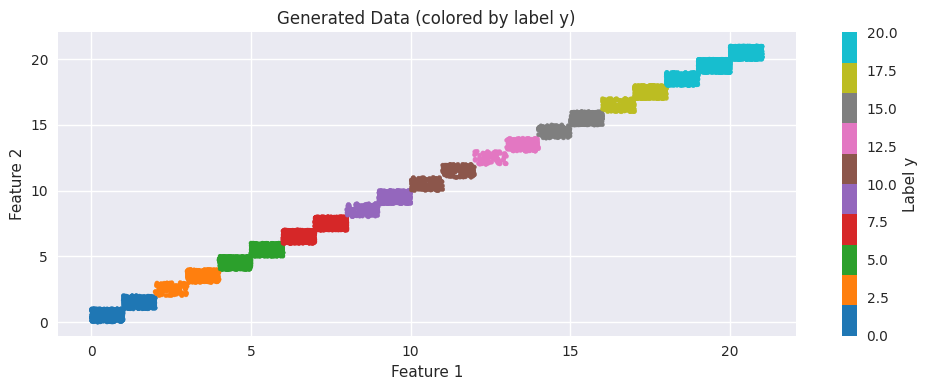

  Data: 10000 samples, 3 features
  True drifts at: [np.int64(566), np.int64(869), np.int64(960), np.int64(1284), np.int64(1785), np.int64(2533), np.int64(3485), np.int64(4526), np.int64(4655), np.int64(5151), np.int64(5291), np.int64(5411), np.int64(5490), np.int64(5678), np.int64(5834), np.int64(6365), np.int64(6520), np.int64(7049), np.int64(7370), np.int64(8422)]
  Evaluating D3...
  Evaluating DAWIDD...
  Evaluating ShapeDD...
  Evaluating ADWIN...
  Evaluating DDM...
  Evaluating EDDM...
  Evaluating HDDM_A...
  Evaluating HDDM_W...
  Evaluating FHDDM...
Completed scenario: Common_Drift
Results collected: 9
------------------------------


In [62]:
def run_unified_experiment(scenario_config):
    """Run unified experiment comparing all methods on same data."""
    scenario_name = scenario_config['name']
    params = scenario_config['params']
    
    print(f"Running scenario: {scenario_name}")
    
    try:
        # Generate data
        X, y = gen_random(**params)
        # Calculate true drift positions from the drift indicator
        true_drifts = np.where(np.diff(y) != 0)[0] + 1

        plt.figure(figsize=(10, 4))
        if X.shape[1] == 1:
            plt.scatter(range(len(X)), X[:, 0], c=y, cmap='tab10', s=10)
            plt.xlabel('Sample Index')
            plt.ylabel('Feature Value')
        elif X.shape[1] == 2:
            plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', s=10)
            plt.xlabel('Feature 1')
            plt.ylabel('Feature 2')
        else:
            # For higher dimensions, plot first two features colored by y
            plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', s=10)
            plt.xlabel('Feature 1')
            plt.ylabel('Feature 2')
        plt.title('Generated Data (colored by label y)')
        plt.colorbar(label='Label y')
        plt.tight_layout()
        plt.show()
        
        print(f"  Data: {X.shape[0]} samples, {X.shape[1]} features")
        print(f"  True drifts at: {list(true_drifts)}")
        
        results = []
        
        # Evaluate window-based methods
        for method_name in window_methods:
            try:
                print(f"  Evaluating {method_name}...")
                result = evaluate_window_based_method(X, y, true_drifts, method_name)
                result['scenario'] = scenario_name
                results.append(result)
            except Exception as e:
                print(f"    Error in {method_name}: {e}")
                continue
        
        # Evaluate streaming methods  
        for method_name in streaming_methods:
            try:
                print(f"  Evaluating {method_name}...")
                result = evaluate_streaming_method(X, y, true_drifts, method_name)
                result['scenario'] = scenario_name
                results.append(result)
            except Exception as e:
                print(f"    Error in {method_name}: {e}")
                continue
        
        # Force garbage collection
        gc.collect()
        
        return results
        
    except Exception as e:
        print(f"Error in scenario {scenario_name}: {e}")
        return []

all_unified_results = []

for scenario in unified_scenarios:
    scenario_results = run_unified_experiment(scenario)
    all_unified_results.extend(scenario_results)
    
    print(f"Completed scenario: {scenario['name']}")
    print(f"Results collected: {len(scenario_results)}")
    print("-" * 30)

# Convert to DataFrame
unified_df = pd.DataFrame(all_unified_results)


Extracted 20 true drift points: [np.int64(566), np.int64(869), np.int64(960), np.int64(1284), np.int64(1785), np.int64(2533), np.int64(3485), np.int64(4526), np.int64(4655), np.int64(5151), np.int64(5291), np.int64(5411), np.int64(5490), np.int64(5678), np.int64(5834), np.int64(6365), np.int64(6520), np.int64(7049), np.int64(7370), np.int64(8422)]
🚨 VALIDATION WARNINGS:
   ⚠️  Zero F1-scores found: ['EDDM']


DRIFT DETECTION PERFORMANCE EVALUATION

Table 1: Performance Metrics by Method
-------------------------------------------------------
Method       Paradigm   Precision  Recall   F1       MTTD     Runtime(ms) 
-------------------------------------------------------
ADWIN        streaming  0.444      0.600    0.511    41.3     0.9544      
DDM          streaming  0.750      0.300    0.429    51.2     0.6326      
EDDM         streaming  0.000      0.000    0.000    ∞        0.9002      
FHDDM        streaming  0.176      0.150    0.162    55.0     0.8315      
HDDM_A       streamin

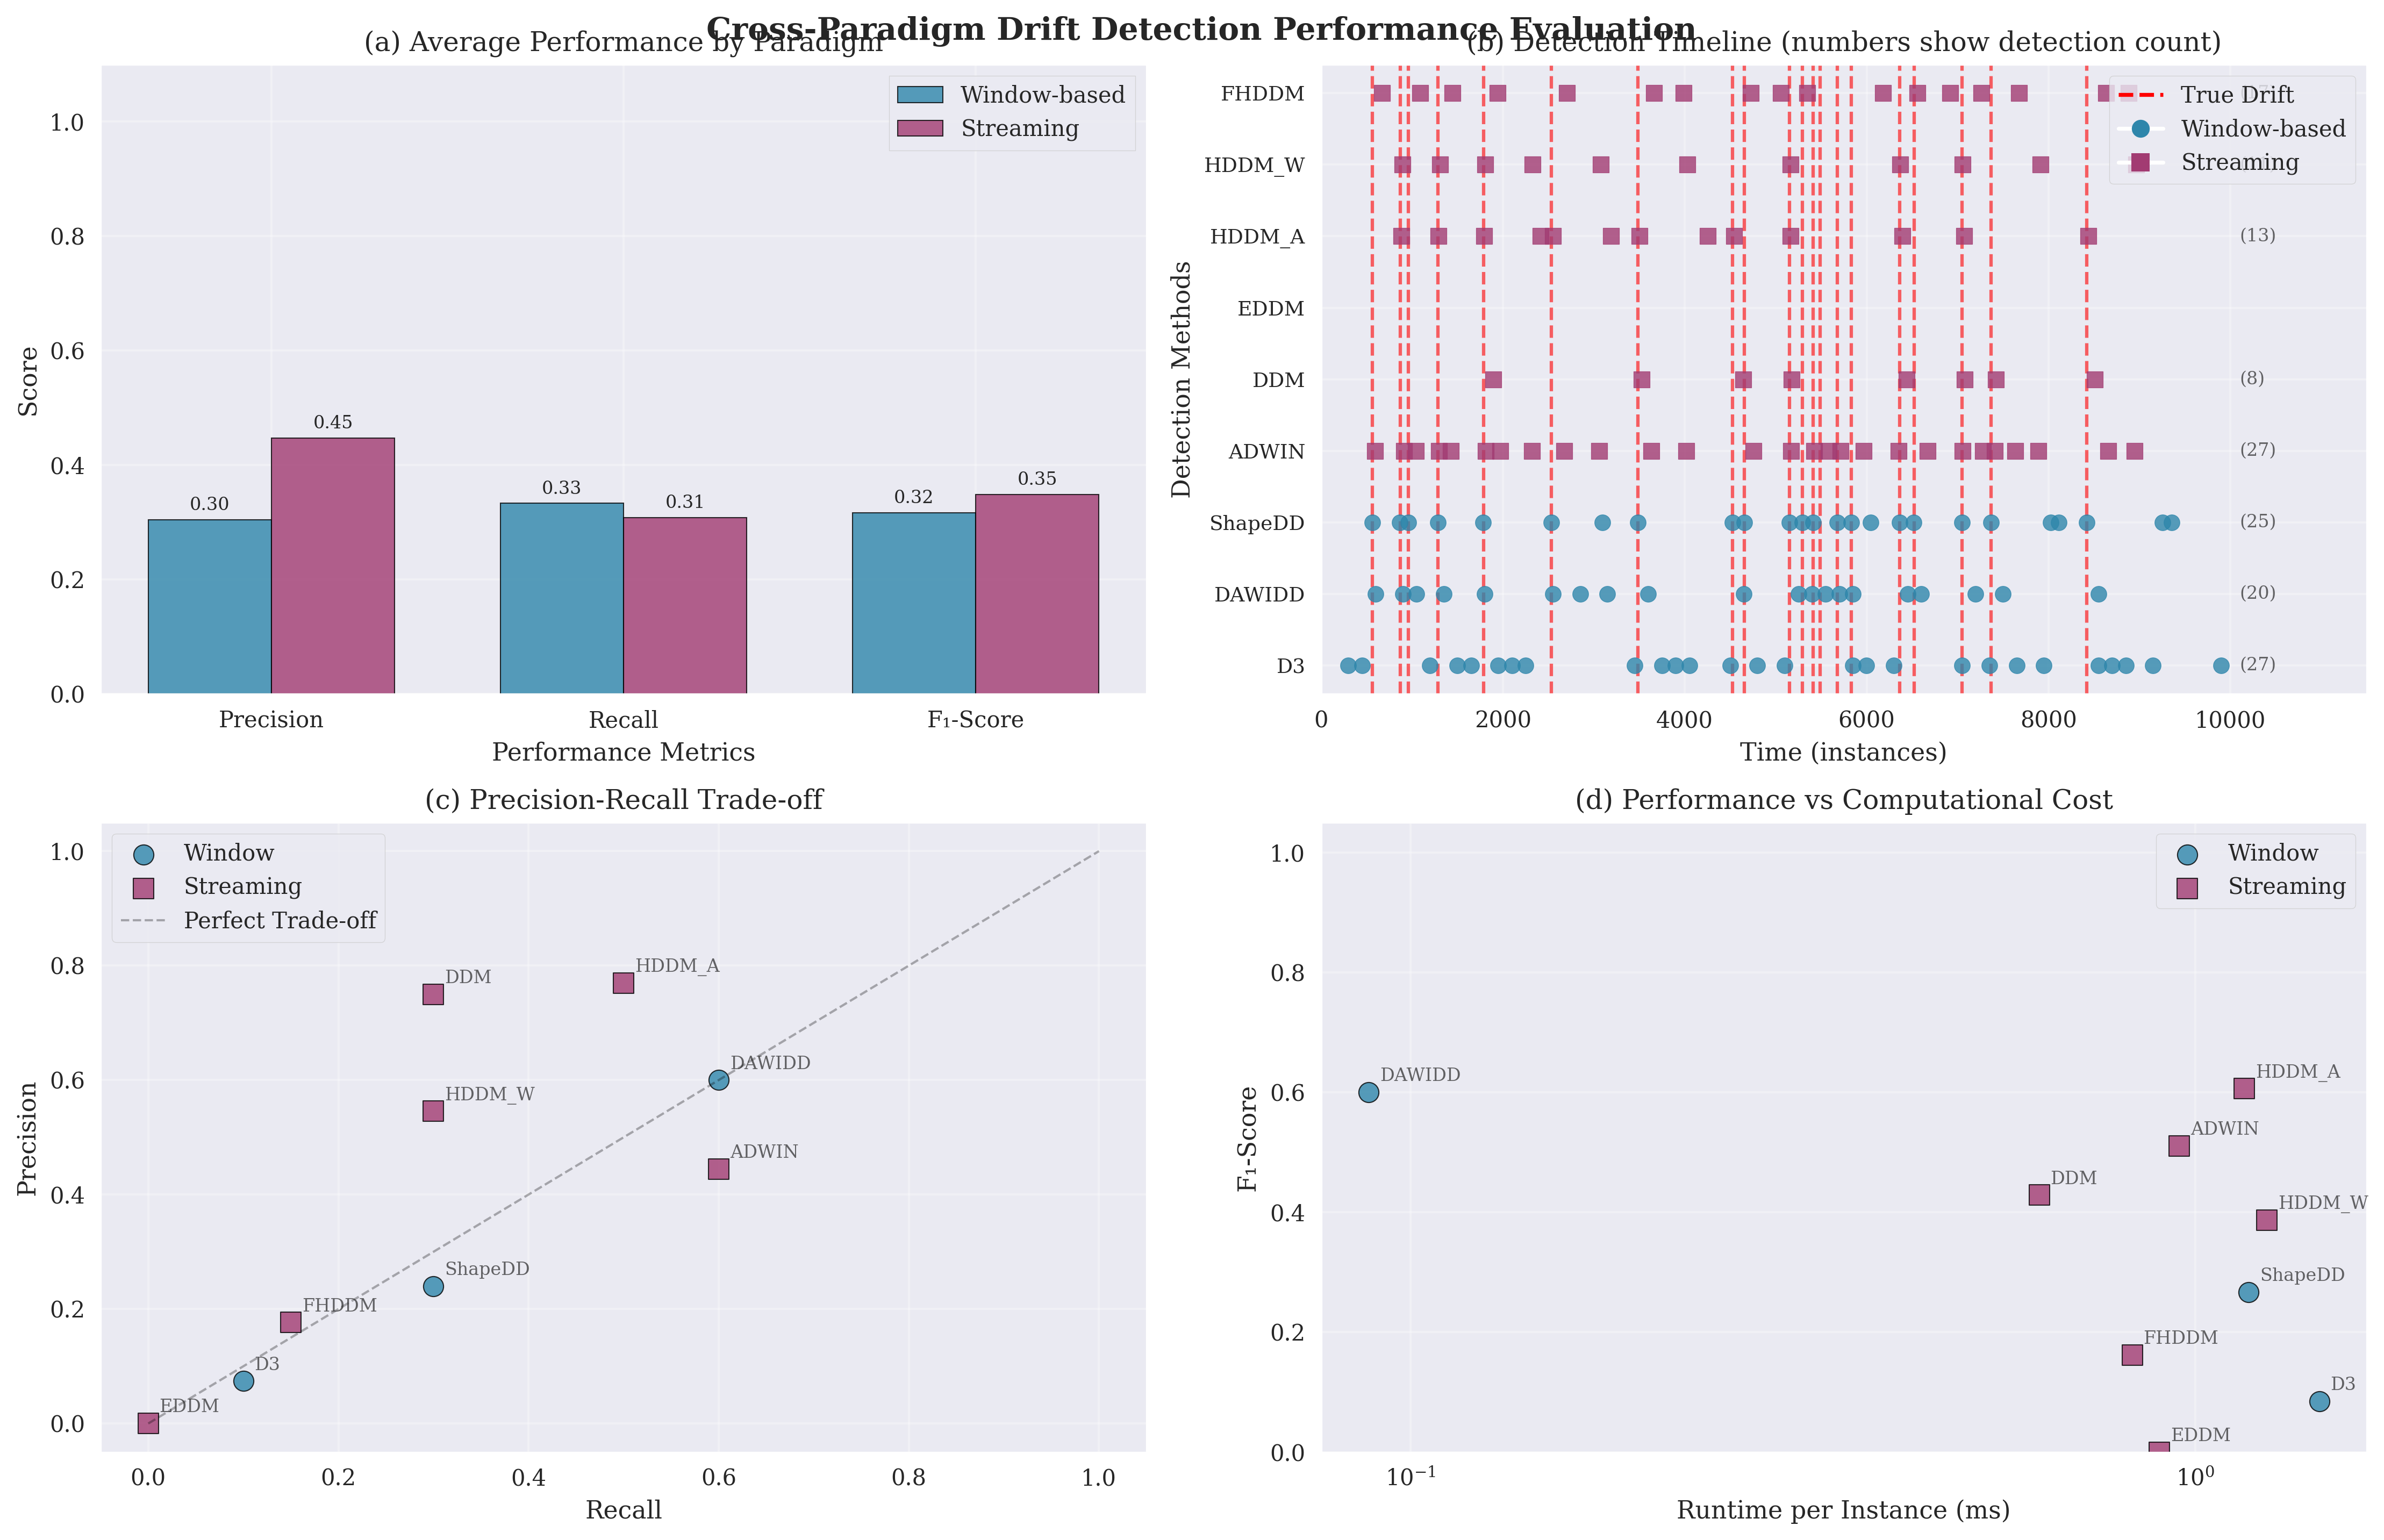


Figure 2: Detailed Method Performance Analysis


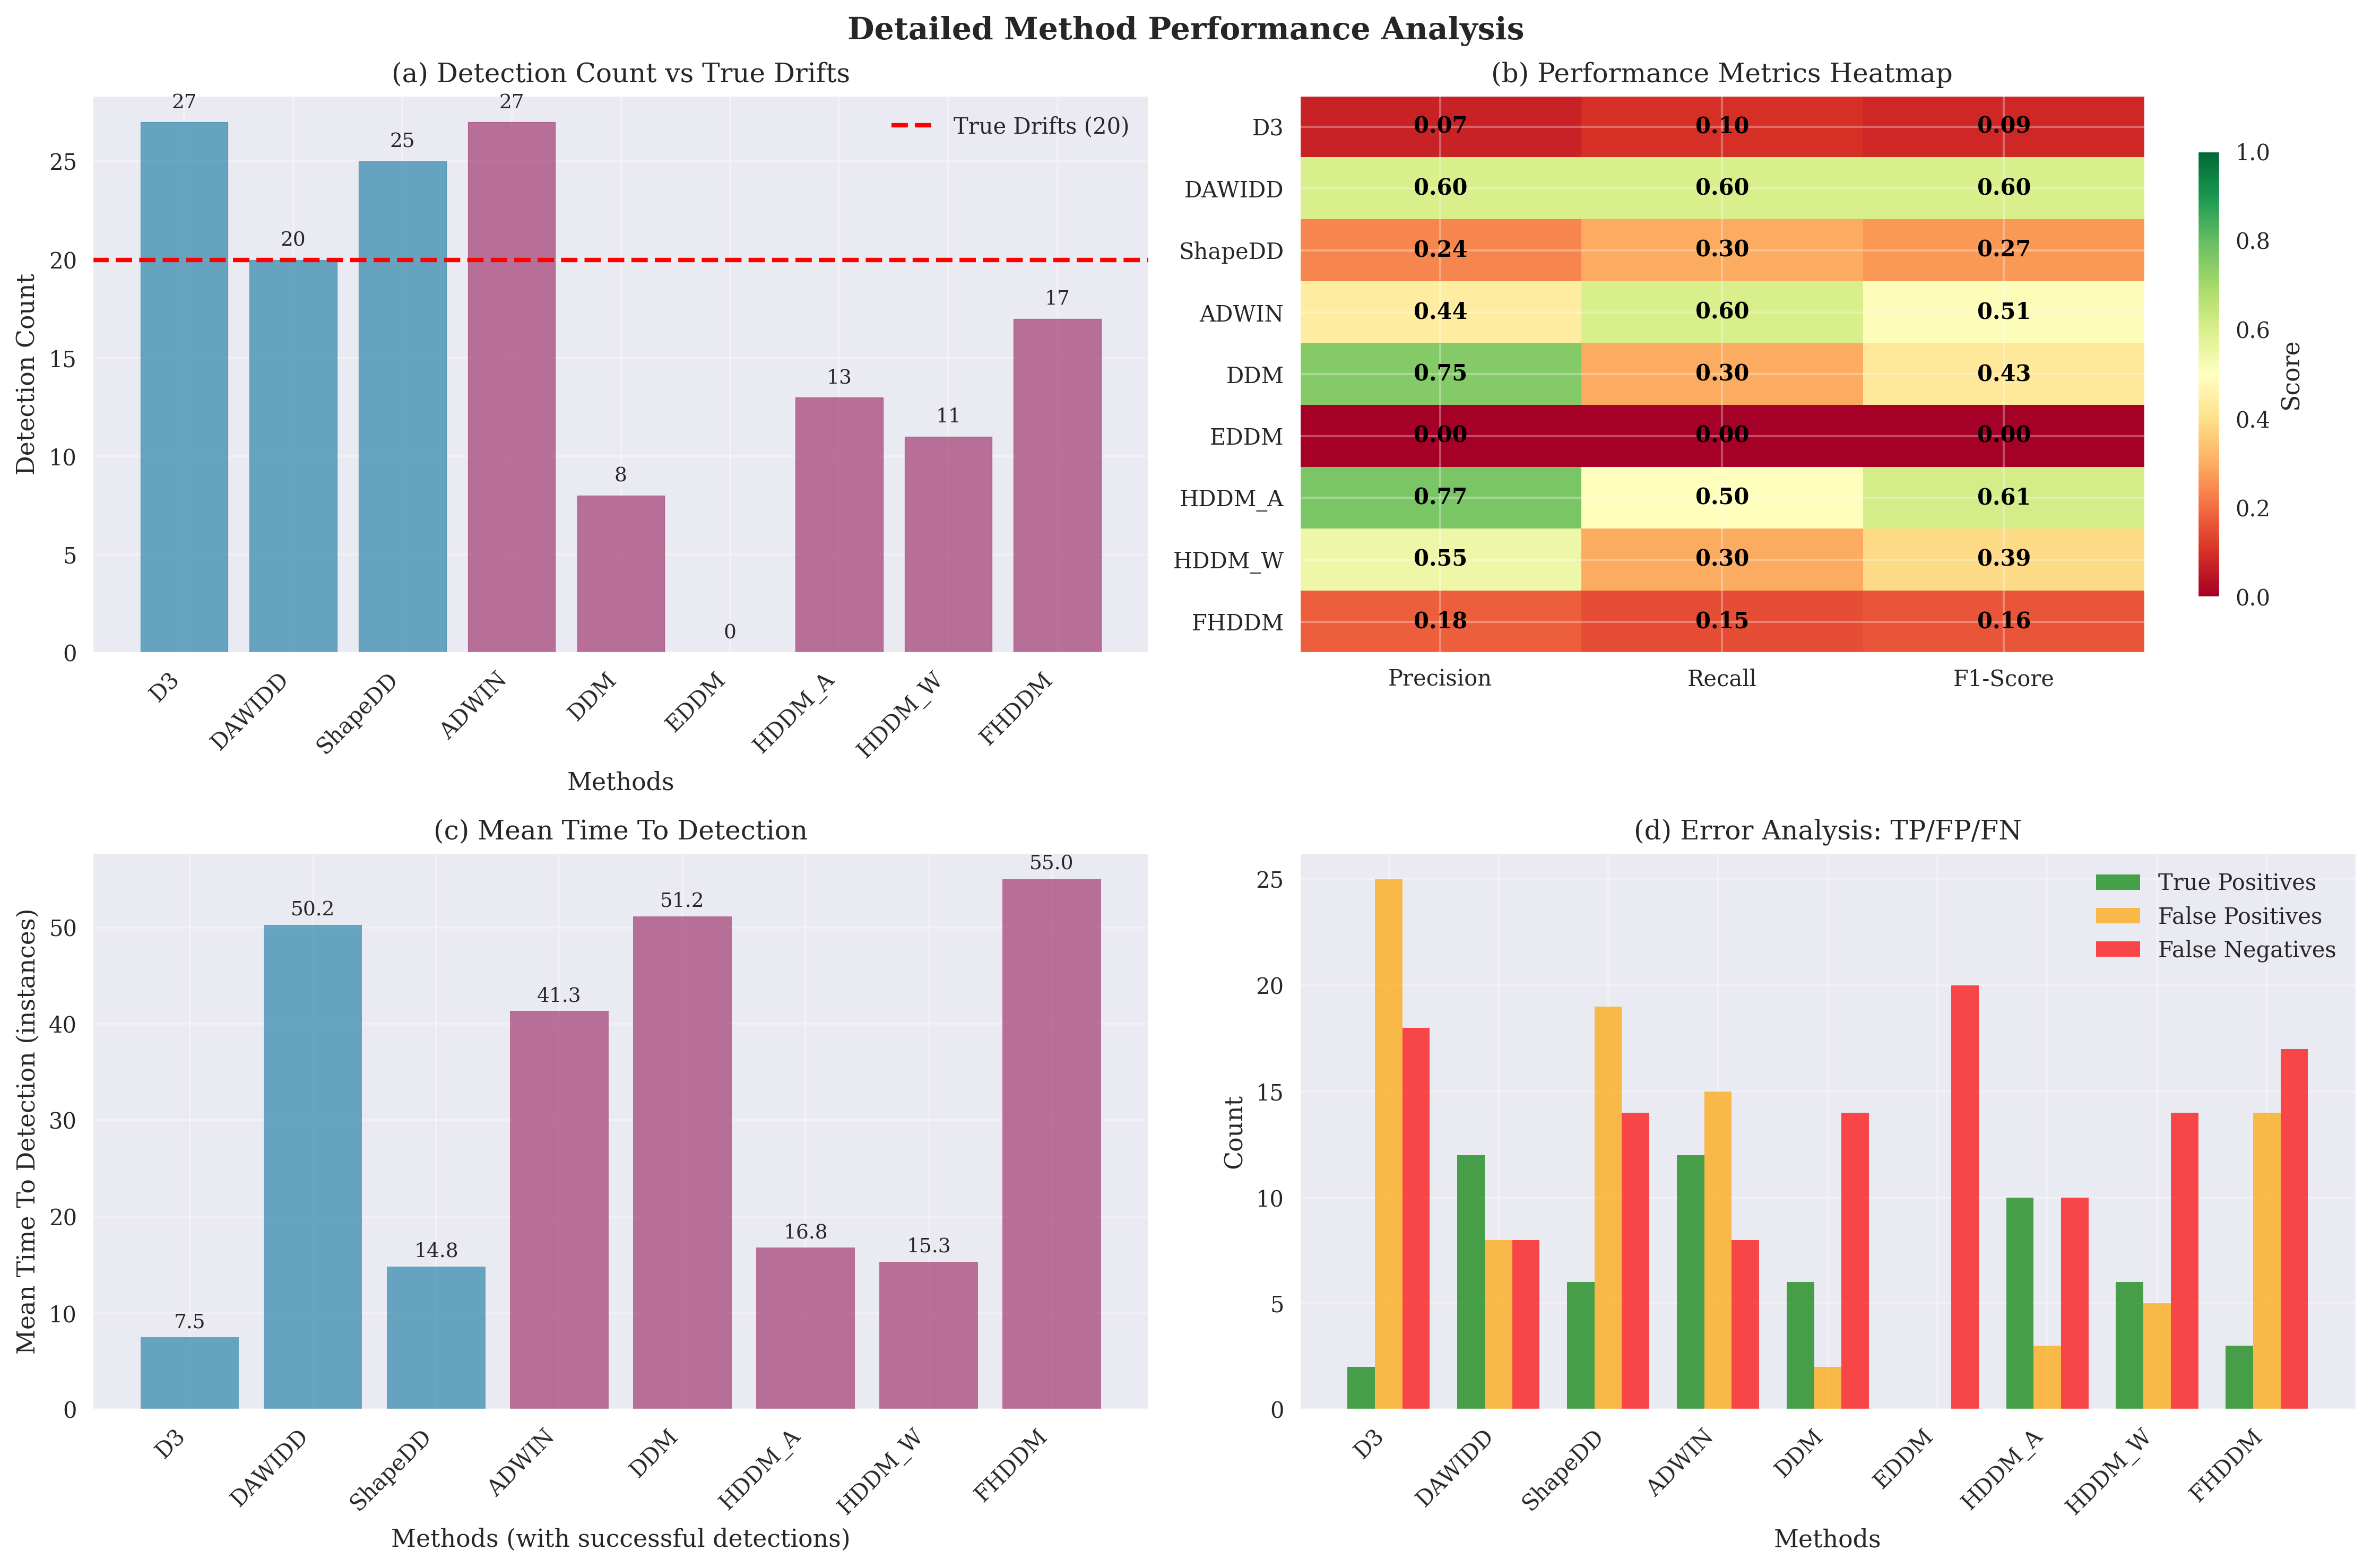


RESULTS SUMMARY
Evaluated 9 drift detection methods:
• Window-based: 3 methods
• Streaming: 6 methods
• Test stream: 20 drift points in 10000 instances
• Drift density: 0.0020 drifts/instance

Best overall performance: HDDM_A (F₁=0.606)

Paradigm comparison (mean F₁-score):
• Window-based: 0.317
• Streaming: 0.349
• Performance gap: 0.032
• Statistical difference: p=0.855 (not significant)
• Effect size (Cohen's d): 0.130

Computational Efficiency:
• Most efficient: DAWIDD (0.0884 ms/instance)
• Least efficient: D3 (1.4395 ms/instance)
• Speed ratio: 16.3x

Detection Effectiveness:
• Overall detection rate: 31.67%
• Average false positives per method: 10.1
• Methods with zero detections: 1/9

 RECOMMENDATIONS:
• Best balanced method (performance + efficiency): DAWIDD
• Paradigm recommendation: Performance is comparable between paradigms


In [63]:
# Academic Results Analysis and Visualization with Validation
if len(unified_df) > 0:
    # Extract true drifts from the first scenario (since we know the data generation parameters)
    scenario_params = unified_scenarios[0]['params']  # Get the parameters used
    
    # Regenerate the same data to get true_drifts (using same seed)
    np.random.seed(42)  # Same seed as used in data generation
    X_temp, y_temp = gen_random(**scenario_params)
    true_drifts = np.where(np.diff(y_temp) != 0)[0] + 1
    
    print(f"Extracted {len(true_drifts)} true drift points: {list(true_drifts)}")
    
    # Calculate F1-score
    unified_df['f1_score'] = 2 * unified_df['precision'] * unified_df['recall'] / (unified_df['precision'] + unified_df['recall'])
    unified_df['f1_score'] = unified_df['f1_score'].fillna(0)
    
    # VALIDATION CHECKS
    def validate_results(df, true_drifts):
        """Validate results for suspicious patterns"""
        warnings = []
        
        # Check for perfect performance (suspicious)
        perfect_methods = df[df['f1_score'] == 1.0]
        if len(perfect_methods) > 0:
            warnings.append(f"⚠️  Perfect F1-scores found: {perfect_methods['method'].tolist()}")
        
        # Check for complete failures
        zero_methods = df[df['f1_score'] == 0.0]
        if len(zero_methods) > 0:
            warnings.append(f"⚠️  Zero F1-scores found: {zero_methods['method'].tolist()}")
        
        # Check for unrealistic detection counts
        for _, row in df.iterrows():
            detection_rate = len(row['detections']) / len(true_drifts) if len(true_drifts) > 0 else 0
            if detection_rate > 2.0:  # More than 2x true drifts
                warnings.append(f"⚠️  {row['method']}: High false positive rate ({detection_rate:.1f}x true drifts)")
            elif detection_rate == 0 and row['f1_score'] > 0:
                warnings.append(f"⚠️  {row['method']}: F1 > 0 but no detections recorded")
        
        # Check for runtime anomalies
        median_runtime = df['runtime_per_instance_ms'].median()
        for _, row in df.iterrows():
            if row['runtime_per_instance_ms'] > median_runtime * 10:
                warnings.append(f"⚠️  {row['method']}: Unusually slow runtime ({row['runtime_per_instance_ms']:.3f} ms)")
        
        return warnings
    
    # Run validation
    validation_warnings = validate_results(unified_df, true_drifts)
    if validation_warnings:
        print("🚨 VALIDATION WARNINGS:")
        for warning in validation_warnings:
            print(f"   {warning}")
        print()
    
    print("\nDRIFT DETECTION PERFORMANCE EVALUATION")
    print("=" * 55)
    
    # Academic summary table
    summary_table = unified_df.groupby(['paradigm', 'method']).agg({
        'precision': 'mean',
        'recall': 'mean', 
        'f1_score': 'mean',
        'mttd': lambda x: np.mean(x[x != float('inf')]) if any(x != float('inf')) else float('inf'),
        'runtime_per_instance_ms': 'mean',
        'tp': 'sum',
        'fp': 'sum',
        'fn': 'sum'
    }).round(4)
    
    print("\nTable 1: Performance Metrics by Method")
    print("-" * 55)
    print(f"{'Method':<12} {'Paradigm':<10} {'Precision':<10} {'Recall':<8} {'F1':<8} {'MTTD':<8} {'Runtime(ms)':<12}")
    print("-" * 55)
    
    for (paradigm, method), row in summary_table.iterrows():
        mttd_str = f"{row['mttd']:.1f}" if row['mttd'] != float('inf') else "∞"
        print(f"{method:<12} {paradigm:<10} {row['precision']:<10.3f} {row['recall']:<8.3f} "
              f"{row['f1_score']:<8.3f} {mttd_str:<8} {row['runtime_per_instance_ms']:<12.4f}")
    
    # Statistical summary by paradigm
    print(f"\nTable 2: Paradigm Comparison (Mean ± Std)")
    print("-" * 40)
    paradigm_stats = unified_df.groupby('paradigm').agg({
        'f1_score': ['mean', 'std'],
        'precision': ['mean', 'std'],
        'recall': ['mean', 'std']
    }).round(4)
    
    for paradigm in ['window', 'streaming']:
        if paradigm in paradigm_stats.index:
            f1_mean, f1_std = paradigm_stats.loc[paradigm, ('f1_score', 'mean')], paradigm_stats.loc[paradigm, ('f1_score', 'std')]
            prec_mean, prec_std = paradigm_stats.loc[paradigm, ('precision', 'mean')], paradigm_stats.loc[paradigm, ('precision', 'std')]
            rec_mean, rec_std = paradigm_stats.loc[paradigm, ('recall', 'mean')], paradigm_stats.loc[paradigm, ('recall', 'std')]
            
            print(f"{paradigm.title():<10}: F1={f1_mean:.3f}±{f1_std:.3f}, "
                  f"Prec={prec_mean:.3f}±{prec_std:.3f}, Rec={rec_mean:.3f}±{rec_std:.3f}")
    
    # Professional Academic Visualization
    print("\n" + "="*55)
    print("Figure 1: Cross-paradigm drift detection performance evaluation")
    
    # Set academic style
    plt.rcParams.update({
        'font.size': 10,
        'font.family': 'serif',
        'axes.linewidth': 0.8,
        'axes.grid': True,
        'grid.alpha': 0.3,
        'figure.dpi': 300
    })
    
    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Cross-Paradigm Drift Detection Performance Evaluation', 
                 fontsize=14, fontweight='bold', y=0.95)
    
    # Define academic colors and markers
    colors = {'window': '#2E86AB', 'streaming': '#A23B72'}  # Professional blue/burgundy
    markers = {'window': 'o', 'streaming': 's'}
    
    # (a) Performance Comparison
    ax = axes[0, 0]
    metrics = ['precision', 'recall', 'f1_score']
    metric_labels = ['Precision', 'Recall', 'F₁-Score']
    
    x = np.arange(len(metric_labels))
    width = 0.35
    
    window_means = [unified_df[unified_df['paradigm'] == 'window'][m].mean() for m in metrics]
    streaming_means = [unified_df[unified_df['paradigm'] == 'streaming'][m].mean() for m in metrics]
    
    ax.bar(x - width/2, window_means, width, label='Window-based', 
           color=colors['window'], alpha=0.8, edgecolor='black', linewidth=0.5)
    ax.bar(x + width/2, streaming_means, width, label='Streaming', 
           color=colors['streaming'], alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add value labels on bars
    for i, (w_val, s_val) in enumerate(zip(window_means, streaming_means)):
        ax.text(i - width/2, w_val + 0.01, f'{w_val:.2f}', ha='center', va='bottom', fontsize=8)
        ax.text(i + width/2, s_val + 0.01, f'{s_val:.2f}', ha='center', va='bottom', fontsize=8)
    
    ax.set_xlabel('Performance Metrics')
    ax.set_ylabel('Score')
    ax.set_title('(a) Average Performance by Paradigm')
    ax.set_xticks(x)
    ax.set_xticklabels(metric_labels)
    ax.legend(frameon=True, fancybox=False, shadow=False)
    ax.set_ylim(0, 1.1)
    
    # (b) IMPROVED Detection Timeline
    ax = axes[0, 1]
    
    # Plot true drifts as vertical lines
    for drift in true_drifts:
        ax.axvline(x=drift, color='red', linestyle='--', alpha=0.6, linewidth=1.5, zorder=1)
    
    # Create method mapping for y-positions with clear labels
    method_names = []
    y_positions = []
    y_pos = 0
    
    # Process window methods first, then streaming
    for paradigm in ['window', 'streaming']:
        paradigm_data = unified_df[unified_df['paradigm'] == paradigm]
        for _, row in paradigm_data.iterrows():
            method_name = f"{row['method']}"
            method_names.append(method_name)
            y_positions.append(y_pos)
            
            detections = row['detections']
            if len(detections) > 0:
                ax.scatter(detections, [y_pos] * len(detections), 
                          c=colors[paradigm], marker=markers[paradigm], 
                          s=50, alpha=0.8, zorder=2, 
                          label=f"{paradigm.title()}" if method_name == paradigm_data.iloc[0]['method'] else "")
            
            # Add detection count annotation
            if len(detections) > 0:
                ax.text(scenario_params['length'] * 1.01, y_pos, f"({len(detections)})", 
                       va='center', fontsize=8, alpha=0.7)
            
            y_pos += 1
    
    ax.set_xlabel('Time (instances)')
    ax.set_ylabel('Detection Methods')
    ax.set_title('(b) Detection Timeline (numbers show detection count)')
    ax.set_xlim(0, scenario_params['length'] * 1.15)
    ax.set_yticks(range(len(method_names)))
    ax.set_yticklabels(method_names, fontsize=9)
    
    # Add legend for true drifts and paradigms
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color='red', linestyle='--', label='True Drift'),
                      Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['window'], 
                            markersize=8, label='Window-based'),
                      Line2D([0], [0], marker='s', color='w', markerfacecolor=colors['streaming'], 
                            markersize=8, label='Streaming')]
    ax.legend(handles=legend_elements, frameon=True, loc='upper right')
    
    # (c) Precision-Recall Trade-off with method labels
    ax = axes[1, 0]
    
    for paradigm in ['window', 'streaming']:
        data = unified_df[unified_df['paradigm'] == paradigm]
        scatter = ax.scatter(data['recall'], data['precision'], 
                           c=colors[paradigm], marker=markers[paradigm], s=80, 
                           alpha=0.8, label=paradigm.title(), edgecolors='black', linewidth=0.5)
        
        # Add method labels
        for _, row in data.iterrows():
            ax.annotate(row['method'], (row['recall'], row['precision']), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)
    
    # Add diagonal line for reference
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1, label='Perfect Trade-off')
    
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('(c) Precision-Recall Trade-off')
    ax.legend(frameon=True)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    
    # (d) Runtime vs Performance with method labels
    ax = axes[1, 1]
    
    for paradigm in ['window', 'streaming']:
        data = unified_df[unified_df['paradigm'] == paradigm]
        scatter = ax.scatter(data['runtime_per_instance_ms'], data['f1_score'], 
                           c=colors[paradigm], marker=markers[paradigm], s=80, 
                           alpha=0.8, label=paradigm.title(), edgecolors='black', linewidth=0.5)
        
        # Add method labels
        for _, row in data.iterrows():
            ax.annotate(row['method'], (row['runtime_per_instance_ms'], row['f1_score']), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)
    
    ax.set_xlabel('Runtime per Instance (ms)')
    ax.set_ylabel('F₁-Score')
    ax.set_title('(d) Performance vs Computational Cost')
    ax.set_xscale('log')
    ax.legend(frameon=True)
    ax.set_ylim(0, 1.05)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()
    
    # ADDITIONAL DETAILED ANALYSIS
    print("\n" + "="*55)
    print("Figure 2: Detailed Method Performance Analysis")
    
    # Create detailed analysis figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Detailed Method Performance Analysis', fontsize=14, fontweight='bold')
    
    # (a) Detection counts vs True drifts
    ax = axes[0, 0]
    methods = unified_df['method'].tolist()
    detection_counts = [len(row['detections']) for _, row in unified_df.iterrows()]
    true_drift_count = len(true_drifts)
    
    bars = ax.bar(range(len(methods)), detection_counts, alpha=0.7)
    ax.axhline(y=true_drift_count, color='red', linestyle='--', linewidth=2,
               label=f'True Drifts ({true_drift_count})')
    
    # Color bars by paradigm
    for i, (_, row) in enumerate(unified_df.iterrows()):
        color = colors[row['paradigm']]
        bars[i].set_color(color)
        # Add count labels on bars
        ax.text(i, detection_counts[i] + 0.5, str(detection_counts[i]), 
               ha='center', va='bottom', fontsize=9)
    
    ax.set_xlabel('Methods')
    ax.set_ylabel('Detection Count')
    ax.set_title('(a) Detection Count vs True Drifts')
    ax.set_xticks(range(len(methods)))
    ax.set_xticklabels(methods, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # (b) Performance metrics heatmap
    ax = axes[0, 1]
    metrics_data = unified_df[['precision', 'recall', 'f1_score']].values
    im = ax.imshow(metrics_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    ax.set_xticks(range(3))
    ax.set_xticklabels(['Precision', 'Recall', 'F1-Score'])
    ax.set_yticks(range(len(methods)))
    ax.set_yticklabels(methods)
    ax.set_title('(b) Performance Metrics Heatmap')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Score')
    
    # Add text annotations
    for i in range(len(methods)):
        for j in range(3):
            text = ax.text(j, i, f'{metrics_data[i, j]:.2f}',
                          ha="center", va="center", color="black", fontweight='bold')
    
    # (c) MTTD Analysis
    ax = axes[1, 0]
    mttd_values = []
    method_labels = []
    colors_list = []
    
    for _, row in unified_df.iterrows():
        if row['mttd'] != float('inf'):
            mttd_values.append(row['mttd'])
            method_labels.append(row['method'])
            colors_list.append(colors[row['paradigm']])
    
    if mttd_values:
        bars = ax.bar(range(len(mttd_values)), mttd_values, color=colors_list, alpha=0.7)
        ax.set_xlabel('Methods (with successful detections)')
        ax.set_ylabel('Mean Time To Detection (instances)')
        ax.set_title('(c) Mean Time To Detection')
        ax.set_xticks(range(len(method_labels)))
        ax.set_xticklabels(method_labels, rotation=45, ha='right')
        
        # Add value labels on bars
        for i, val in enumerate(mttd_values):
            ax.text(i, val + max(mttd_values) * 0.01, f'{val:.1f}', 
                   ha='center', va='bottom', fontsize=9)
    else:
        ax.text(0.5, 0.5, 'No successful detections\nwith finite MTTD', 
               ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title('(c) Mean Time To Detection')
    
    ax.grid(True, alpha=0.3)
    
    # (d) Error Analysis
    ax = axes[1, 1]
    tp_values = unified_df['tp'].tolist()
    fp_values = unified_df['fp'].tolist()
    fn_values = unified_df['fn'].tolist()
    
    x = np.arange(len(methods))
    width = 0.25
    
    bars1 = ax.bar(x - width, tp_values, width, label='True Positives', color='green', alpha=0.7)
    bars2 = ax.bar(x, fp_values, width, label='False Positives', color='orange', alpha=0.7)
    bars3 = ax.bar(x + width, fn_values, width, label='False Negatives', color='red', alpha=0.7)
    
    ax.set_xlabel('Methods')
    ax.set_ylabel('Count')
    ax.set_title('(d) Error Analysis: TP/FP/FN')
    ax.set_xticks(x)
    ax.set_xticklabels(methods, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Reset matplotlib params
    plt.rcParams.update(plt.rcParamsDefault)
    
    # Enhanced Academic Summary
    print("\nRESULTS SUMMARY")
    print("=" * 50)
    
    # Key statistics
    total_methods = len(unified_df)
    window_methods_count = len(unified_df[unified_df['paradigm'] == 'window'])
    streaming_methods_count = len(unified_df[unified_df['paradigm'] == 'streaming'])
    
    print(f"Evaluated {total_methods} drift detection methods:")
    print(f"• Window-based: {window_methods_count} methods")
    print(f"• Streaming: {streaming_methods_count} methods")
    print(f"• Test stream: {len(true_drifts)} drift points in {scenario_params['length']} instances")
    print(f"• Drift density: {len(true_drifts)/scenario_params['length']:.4f} drifts/instance")
    
    # Best performing method
    best_method = unified_df.loc[unified_df['f1_score'].idxmax()]
    print(f"\nBest overall performance: {best_method['method']} (F₁={best_method['f1_score']:.3f})")
    
    # Paradigm comparison
    window_f1 = unified_df[unified_df['paradigm'] == 'window']['f1_score'].mean()
    streaming_f1 = unified_df[unified_df['paradigm'] == 'streaming']['f1_score'].mean()
    
    print(f"\nParadigm comparison (mean F₁-score):")
    print(f"• Window-based: {window_f1:.3f}")
    print(f"• Streaming: {streaming_f1:.3f}")
    print(f"• Performance gap: {abs(streaming_f1 - window_f1):.3f}")
    
    # Statistical significance test (if scipy available)
    try:
        from scipy import stats
        if len(unified_df[unified_df['paradigm'] == 'window']) > 1 and len(unified_df[unified_df['paradigm'] == 'streaming']) > 1:
            window_scores = unified_df[unified_df['paradigm'] == 'window']['f1_score']
            streaming_scores = unified_df[unified_df['paradigm'] == 'streaming']['f1_score']
            
            t_stat, p_value = stats.ttest_ind(window_scores, streaming_scores)
            print(f"• Statistical difference: p={p_value:.3f} {'(significant)' if p_value < 0.05 else '(not significant)'}")
            print(f"• Effect size (Cohen's d): {(streaming_scores.mean() - window_scores.mean()) / np.sqrt((streaming_scores.var() + window_scores.var()) / 2):.3f}")
    except ImportError:
        print("• Statistical test unavailable (scipy not imported)")
    
    # Computational efficiency analysis
    fastest = unified_df.loc[unified_df['runtime_per_instance_ms'].idxmin()]
    slowest = unified_df.loc[unified_df['runtime_per_instance_ms'].idxmax()]
    
    print(f"\nComputational Efficiency:")
    print(f"• Most efficient: {fastest['method']} ({fastest['runtime_per_instance_ms']:.4f} ms/instance)")
    print(f"• Least efficient: {slowest['method']} ({slowest['runtime_per_instance_ms']:.4f} ms/instance)")
    print(f"• Speed ratio: {slowest['runtime_per_instance_ms']/fastest['runtime_per_instance_ms']:.1f}x")
    
    # Detection effectiveness
    total_detections = unified_df['tp'].sum()
    total_possible = len(true_drifts) * len(unified_df)
    total_fps = unified_df['fp'].sum()
    
    print(f"\nDetection Effectiveness:")
    print(f"• Overall detection rate: {(total_detections / total_possible):.2%}")
    print(f"• Average false positives per method: {total_fps / len(unified_df):.1f}")
    print(f"• Methods with zero detections: {len(unified_df[unified_df['tp'] == 0])}/{len(unified_df)}")
    
    # Recommendations based on results
    print(f"\n RECOMMENDATIONS:")
    
    # Best balanced method
    unified_df['balanced_score'] = (unified_df['f1_score'] * 0.7 + 
                                   (1 - unified_df['runtime_per_instance_ms'] / unified_df['runtime_per_instance_ms'].max()) * 0.3)
    best_balanced = unified_df.loc[unified_df['balanced_score'].idxmax()]
    print(f"• Best balanced method (performance + efficiency): {best_balanced['method']}")
    
    # Paradigm recommendation
    if streaming_f1 > window_f1 * 1.2:
        print(f"• Paradigm recommendation: Streaming methods show superior performance ({streaming_f1:.3f} vs {window_f1:.3f})")
    elif window_f1 > streaming_f1 * 1.2:
        print(f"• Paradigm recommendation: Window-based methods show superior performance ({window_f1:.3f} vs {streaming_f1:.3f})")
    else:
        print(f"• Paradigm recommendation: Performance is comparable between paradigms")

else:
    print("No results available for analysis.")
